In [1]:
import torch
import torch.nn as nn # NN networks (CNN, RNN, losses)
import torch.optim as optim # Aptimizers (Adam, Adadelta, Adagrad)
import torch.nn.functional as F # Activarions func (ReLU, Sigmoid) also included in nn
from torch.utils.data import DataLoader, Dataset # Dataset manager
import torchvision.datasets as datasets # Datasets
import torchvision.transforms as transforms # Transformation to datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set(rc={"figure.figsize": (13, 10)})

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TARGET = "failure"
SEED = 0

# Data Preparation

In [3]:
train_data = pd.read_csv("./data/train.csv").set_index("id")
valid_data = pd.read_csv("./data/test.csv").set_index("id")
datasets = [train_data, valid_data]
train_data.shape, valid_data.shape

((26570, 25), (20775, 24))

In [4]:
# load csv and set id column as index

# lable encode categorical columns
cat_cols = ['product_code', 'attribute_0', 'attribute_1']

for data in datasets:
    for col in cat_cols:
        data[col] = data[col].astype('category').cat.codes


In [5]:
print(f"Train NAs: {train_data.isna().sum().sum()}\nTest NAs: {valid_data.isna().sum().sum()}")

Train NAs: 20273
Test NAs: 15709


In [6]:
for data in datasets:
    for col in data.filter(regex="measurement_").columns.tolist():
        data[col] = data.groupby(["product_code", "attribute_0", "attribute_1"])[col].transform(lambda x: x.fillna(x.median()))
        
    data['loading'] = data.groupby("product_code")["loading"].transform(lambda x: x.fillna(x.median()))

print(f"Train NAs: {train_data.isna().sum().sum()}\nTest NAs: {valid_data.isna().sum().sum()}")

Train NAs: 0
Test NAs: 0


In [7]:
# apply StandardScaler to continuous columns
scaling_dropped_columns = ['product_code','attribute_0', 'attribute_1',  'attribute_2', 'attribute_3']
scaler = StandardScaler()
cols = train_data.columns.drop(scaling_dropped_columns + [TARGET]).tolist()
train_data[cols] = scaler.fit_transform(train_data[cols])


scaler = StandardScaler()
cols = valid_data.columns.drop(scaling_dropped_columns).tolist()
valid_data[cols] = scaler.fit_transform(valid_data[cols])

In [8]:
train_data.rename(columns={"failure": "failure_true"}, inplace=True)
d = {0: 1, 1: 0}
train_data["failure_false"] = train_data["failure_true"].map(d)

train_data.head()


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure_true,failure_false
id,,,,,,,,,,,,,,,,,,,,,
0,0,-1.227197,1,2,9,5,-0.101025,-0.055370,-0.681939,0.250049,...,-0.188813,-1.068856,2.413520,-0.558904,-0.014704,-1.311779,-1.081371,0.533171,0,1
1,0,-1.103898,1,2,9,5,1.599402,-1.246039,-0.984141,0.424097,...,1.332845,-0.851891,0.036948,-0.824915,-0.432792,-0.400329,-0.504569,-0.162795,0,1
2,0,-1.167221,1,2,9,5,1.113565,-1.722306,-0.379737,0.267152,...,-0.372461,0.192381,1.449204,0.947592,1.795620,-0.601906,0.905460,-0.321265,0,1
3,0,-0.687412,1,2,9,5,1.356484,-1.484172,-0.077535,-0.499464,...,0.166095,-0.539623,-1.162399,-0.360964,-0.337567,0.777659,0.434029,1.060658,0,1
4,0,1.551783,1,2,9,5,0.384811,-1.484172,0.526868,1.563960,...,0.702465,0.511408,0.502170,0.473789,-2.285168,-1.232085,-0.028874,-1.029515,0,1


In [9]:
reduce_columns = [f"measurement_{i}" for i in range(0, 3)] + \
    [f"measurement_{i}" for i in range(10, 18)]


In [10]:
train_data = train_data.drop(columns=reduce_columns)
valid_data = valid_data.drop(columns=reduce_columns)

# Create DataLoader

In [11]:
class KaggleData(Dataset):
    def __init__(self, data, TARGET) -> None:
        super().__init__()
        
        X = data.drop(columns=TARGET).values
        y = data[TARGET].values
        
        self.X_train = torch.tensor(X, dtype=torch.float32)
        self.y_train = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X_train)
    
    def __getitem__(self, index):
        return self.X_train[index], self.y_train[index]
        

# Create a Model

In [12]:
len_train_data = len(train_data)
input_size = len(train_data.columns) - 2

train_amount = int(len_train_data * 0.25)
test_amount = len_train_data - train_amount

num_classes = 2
# Hyperparametrs
learning_rate = 0.001
num_epoches = 40
batch_size = 64

In [13]:

test_train_data = KaggleData(train_data, ["failure_true", "failure_false"])
train_amount = 20000
test_amount = 26570 - train_amount
train_set, test_set = torch.utils.data.random_split(test_train_data, [train_amount, test_amount])

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [14]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        
        self.first_sequential = nn.Sequential(
            nn.Linear(input_size, 70)
            
        )
        
        
        self.fcs = nn.Sequential(
            nn.Linear(input_size, 100),
            # nn.BatchNorm1d(100),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
            nn.Dropout(p=0.5),
            nn.Linear(100, num_classes),
            
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.fcs(x)
        return x


In [23]:
# Initialize model
model = NN(input_size=input_size, num_classes=num_classes).to(device=device)

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1, 5]).to(device=device))
# criterion = nn.BCELoss(weight=torch.tensor([1, 10]).to(device=device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
# Train model
losses = []
for epoch in range(num_epoches):
    for batch_ind, (data, targets) in enumerate(train_loader):
        # Data on cude
        data = data.to(device=device)
        # targets = targets.type(torch.LongTensor)
        targets = targets.to(device=device)
        
        # Forawrd
        scores = model(data) # Equal to model.forward(data)
        loss = criterion(scores, targets)
        # Backprop
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()
        
        if batch_ind % 100 == 0:
            losses.append(loss.item())
    print(scores[0].round().tolist(), targets[0].tolist(), loss.item())


[0.0, 1.0] [0.0, 1.0] 1.538395643234253
[0.0, 1.0] [0.0, 1.0] 1.5037469863891602
[0.0, 1.0] [1.0, 0.0] 1.4794085025787354
[0.0, 1.0] [0.0, 1.0] 1.5032051801681519
[0.0, 1.0] [1.0, 0.0] 1.5031715631484985
[0.0, 1.0] [1.0, 0.0] 1.5269510746002197
[0.0, 1.0] [1.0, 0.0] 1.503329873085022
[0.0, 1.0] [0.0, 1.0] 1.5189632177352905
[0.0, 1.0] [0.0, 1.0] 1.4952058792114258
[0.0, 1.0] [0.0, 1.0] 1.5030782222747803
[0.0, 1.0] [0.0, 1.0] 1.519000768661499
[0.0, 1.0] [1.0, 0.0] 1.4872626066207886
[0.0, 1.0] [1.0, 0.0] 1.5030841827392578
[0.0, 1.0] [0.0, 1.0] 1.5346920490264893
[0.0, 1.0] [0.0, 1.0] 1.51888108253479
[0.0, 1.0] [0.0, 1.0] 1.5268023014068604
[0.0, 1.0] [0.0, 1.0] 1.495168685913086
[0.0, 1.0] [0.0, 1.0] 1.534688115119934
[0.0, 1.0] [0.0, 1.0] 1.5347033739089966
[0.0, 1.0] [0.0, 1.0] 1.5267763137817383
[0.0, 1.0] [1.0, 0.0] 1.5188727378845215
[0.0, 1.0] [0.0, 1.0] 1.5030543804168701
[0.0, 1.0] [0.0, 1.0] 1.4872359037399292
[0.0, 1.0] [0.0, 1.0] 1.5109575986862183
[0.0, 1.0] [1.0, 0.0] 1

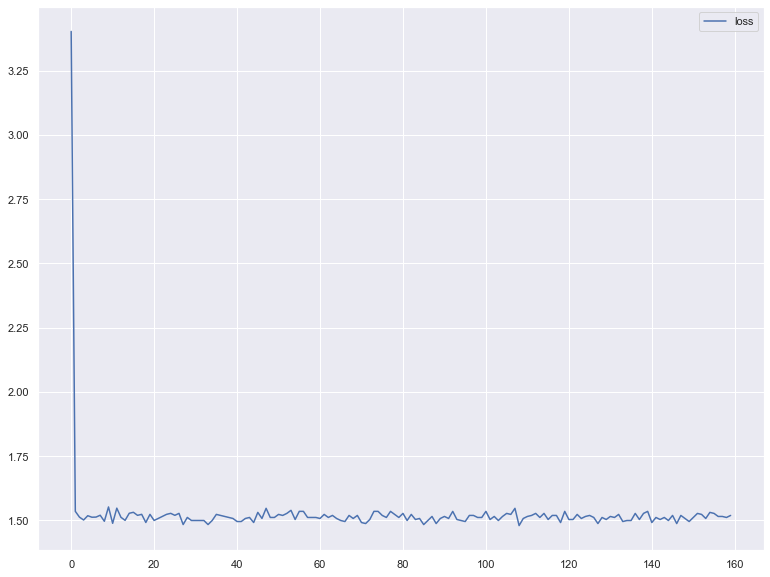

In [25]:
df = pd.DataFrame({"loss": losses})
sns.set(rc={"figure.figsize": (13, 10)})
df.plot()
None

In [26]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    res = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device=device)
            y = y.to(device=device)
            
            pred = model(x).round()
            score_tmp = (pred[:, 0] - y[:, 0]).abs()
            res += score_tmp.sum()
    print((test_amount - res.item()) / test_amount)

    
check_accuracy(test_loader, model)

0.7855403348554033


In [27]:
def create_submission(valid_data, model):
    model.eval()
    preds = torch.zeros(len(valid_data.values), 1)
    with torch.no_grad():
        for i, row in enumerate(valid_data.values):
            row = torch.tensor([row], dtype=torch.float32).to(device=device).round()
            score = model(row)
            preds[i] = score[0][0]
    return preds


preds = create_submission(valid_data, model)


In [28]:
res = preds.T.tolist()[0]

In [29]:
submission = pd.read_csv("./data/sample_submission.csv")
submission[TARGET] = res
submission[TARGET] = submission[TARGET].astype(int)
submission.head()

,id,failure
0,26570,0
1,26571,0
2,26572,0
3,26573,0
4,26574,0


In [30]:
submission[["id", TARGET]].to_csv("./data/solution.csv", index=False)